# Auto Encoders:

Compactação de imagens

## Step 1: import libs

In [1]:
from torchvision import datasets, transforms
import torch
from torch import nn, optim
import matplotlib.pyplot as plt


In [2]:
torch.manual_seed(123)

## Step 2: Dataset

In [3]:
resize_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

In [4]:
dataset_train = datasets.CIFAR10('CIFAR10-data',
                               train=True,
                               download = True,
                               transform = resize_transform)
train_dataloader = torch.utils.data.DataLoader(dataset_train,
                                               batch_size=20,
                                               shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 46012117.30it/s]


Extracting CIFAR10-data/cifar-10-python.tar.gz to CIFAR10-data


In [5]:
dataset_val = datasets.CIFAR10('CIFAR10-data',
                               train=False,
                               download = True,
                               transform = resize_transform)
val_dataloader = torch.utils.data.DataLoader(dataset_val,
                                               batch_size=20,
                                               shuffle=True)

Files already downloaded and verified


## Step 3: Criar o autoencoder

In [6]:
class autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    #camadas do encoder
    self.enc0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
    self.enc1 = nn.Conv2d(in_channels=16,
                          out_channels=8,
                          kernel_size=(3, 3),
                          padding=(1, 1))
    self.enc2 = nn.Conv2d(in_channels=8,
                          out_channels=8,
                          kernel_size=(3, 3),
                          stride=(2, 2),
                          padding=(1, 1))
    self.maxpool0 = nn.MaxPool2d(kernel_size= (2, 2))
    self.maxpool1 = nn.MaxPool2d(kernel_size= (2, 2), padding = (1, 1))

    self.flatten = nn.Flatten()

    #camadas do decoder
    self.dec0 = nn.Conv2d(in_channels=8,
                          out_channels=8,
                          kernel_size= (3, 3),
                          padding = (1, 1))
    self.dec1 = nn.Conv2d(in_channels=8,
                          out_channels=8,
                          kernel_size= (3, 3),
                          padding = (1, 1))
    self.dec2 = nn.Conv2d(in_channels=8,
                          out_channels=16,
                          kernel_size= (3, 3))
    self.dec3 = nn.Conv2d(in_channels=16,
                          out_channels=3,
                          kernel_size=(3, 3),
                          padding = (1, 1))

    self.upsampling = nn.UpsamplingBilinear2d(scale_factor=2)
    #camadas de ativação
    self.activation0 = nn.ReLU()
    self.activation1 = nn.Sigmoid()

  def forward(self, x):
    x = self.maxpool0(self.activation0(self.enc0(x))) # 28 x 28 -> 26 x 26 -> 13x13
    x = self.maxpool1(self.activation0(self.enc1(x))) # 13 x 13 -> 7 x 7
    x = self.flatten(self.activation0(self.enc2(x)))  # 7 x 7 -> 4 x 4
    x = x.view(-1, 8, 4, 4)
    x = self.upsampling(self.activation0(self.dec0(x))) # 4 x 4 -> 8 x 8
    x = self.upsampling(self.activation0(self.dec1(x))) # 8 x 8 -> 16 x 16
    x = self.upsampling(self.activation0(self.dec2(x))) # 16 x 16 -> 28 x 28
    x = self.activation1(self.dec3(x))
    return x

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
model = autoencoder().to(device)

In [9]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Step 4: Treinamento do autoencoder

In [10]:
for epoch in range(50):

  running_loss_train = 0.
  for data in train_dataloader:
    model.train()
    inputs, _ = data
    inputs = inputs.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)

    loss = loss_fn(outputs, inputs.view(*outputs.shape))
    loss.backward()
    optimizer.step()

    running_loss_train += loss.item()

  running_loss_val = 0.
  for data in val_dataloader:
    model.eval()
    with torch.inference_mode():
      inputs, _ = data
      inputs = inputs.to(device)
      outputs = model(inputs)
    loss = loss_fn(outputs, inputs.view(*outputs.shape))
    running_loss_val += loss.item()

  print(f"Epoch: {epoch+1} "
        f"train_loss: {running_loss_train/len(train_dataloader):.3f} "
        f"Val_loss: {running_loss_val/len(val_dataloader):.3f}"
        )

Epoch: 1 train_loss: 0.605 Val_loss: 0.601
Epoch: 2 train_loss: 0.593 Val_loss: 0.591
Epoch: 3 train_loss: 0.591 Val_loss: 0.593
Epoch: 4 train_loss: 0.590 Val_loss: 0.594
Epoch: 5 train_loss: 0.589 Val_loss: 0.588
Epoch: 6 train_loss: 0.589 Val_loss: 0.588
Epoch: 7 train_loss: 0.589 Val_loss: 0.588
Epoch: 8 train_loss: 0.588 Val_loss: 0.589
Epoch: 9 train_loss: 0.588 Val_loss: 0.588
Epoch: 10 train_loss: 0.588 Val_loss: 0.588
Epoch: 11 train_loss: 0.588 Val_loss: 0.590
Epoch: 12 train_loss: 0.588 Val_loss: 0.589
Epoch: 13 train_loss: 0.588 Val_loss: 0.588
Epoch: 14 train_loss: 0.588 Val_loss: 0.590
Epoch: 15 train_loss: 0.588 Val_loss: 0.587
Epoch: 16 train_loss: 0.588 Val_loss: 0.586
Epoch: 17 train_loss: 0.588 Val_loss: 0.590
Epoch: 18 train_loss: 0.588 Val_loss: 0.590
Epoch: 19 train_loss: 0.588 Val_loss: 0.592
Epoch: 20 train_loss: 0.588 Val_loss: 0.587
Epoch: 21 train_loss: 0.587 Val_loss: 0.587
Epoch: 22 train_loss: 0.587 Val_loss: 0.593
Epoch: 23 train_loss: 0.587 Val_loss: 0.5

## Step 5: Gerando o Encoder

In [11]:
for i, layer in enumerate(list(model.children())):
  print(i, layer)

0 Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
1 Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
3 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
4 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
5 Flatten(start_dim=1, end_dim=-1)
6 Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
9 Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
10 UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
11 ReLU()
12 Sigmoid()


In [12]:
class encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.enc0 = list(model.children())[0]
    self.enc1 = list(model.children())[1]
    self.enc2 = list(model.children())[2]

    self.maxpool0 = list(model.children())[3]
    self.maxpool1 = list(model.children())[4]

    self.flatten = list(model.children())[5]

    self.activation0 = list(model.children())[11]

  def forward(self, x):
    x = self.maxpool0(self.activation0(self.enc0(x)))
    x = self.maxpool1(self.activation0(self.enc1(x)))
    x = self.flatten(self.activation0(self.enc2(x)))

    return x

In [13]:
model1 = encoder().to(device)

## Step 6: Gerar o Decoder

In [14]:
class decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.dec0 = list(model.children())[6]
    self.dec1 = list(model.children())[7]
    self.dec2 = list(model.children())[8]
    self.dec3 = list(model.children())[9]

    self.upsampling = list(model.children())[10]

    self.activation0 = list(model.children())[11]
    self.activation1 = list(model.children())[12]

  def forward(self, x):
    x = x.view(-1, 8, 4, 4)
    x = self.upsampling(self.activation0(self.dec0(x)))
    x = self.upsampling(self.activation0(self.dec1(x)))
    x = self.upsampling(self.activation0(self.dec2(x)))
    x = self.activation1(self.dec3(x))
    return x

In [15]:
model2 = decoder().to(device)

## Step 7: Vizualizar os resultados

In [16]:
numero_imagens = 10
imagens_teste = next(iter(val_dataloader))[0][:numero_imagens]
imagens_teste = imagens_teste.to(device)

In [17]:
imagens_teste.shape

torch.Size([10, 3, 28, 28])

In [18]:
#codificação das imagens de teste - model1
model1.eval()
with torch.inference_mode():
  imagens_codificadas = model1(imagens_teste)

In [19]:
imagens_codificadas.shape

torch.Size([10, 128])

In [20]:
8*4*4

128

In [21]:
#decodificar as imagens
model2.eval()
with torch.inference_mode():
  imagens_decodificadas = model2(imagens_codificadas)

In [22]:
imagens_decodificadas.shape

torch.Size([10, 3, 28, 28])

In [23]:
imagens_teste = imagens_teste.detach().cpu().numpy().reshape(-1, 28, 28)
imagens_codificadas = imagens_codificadas.detach().cpu().numpy().reshape(-1, 16, 8)
imagens_decodificadas  = imagens_decodificadas.detach().cpu().numpy().reshape(-1, 28, 28)

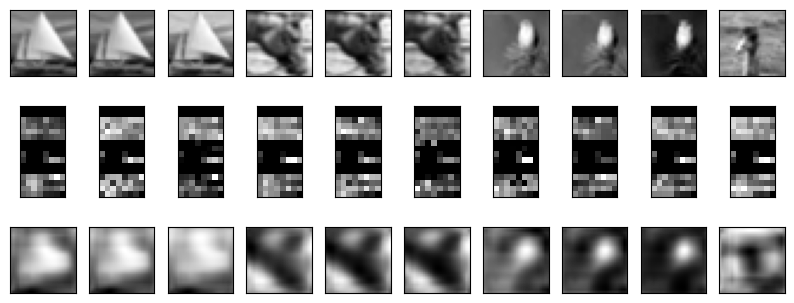

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=numero_imagens, figsize=(10, 4))
for imagens, ax_row in zip([imagens_teste, imagens_codificadas, imagens_decodificadas], axes):
  for img, ax in zip(imagens, ax_row):
    ax.imshow(img, cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)